# Imports

In [2]:
import functions as fc
import json
import pandas as pd
import numpy as np
import sqlalchemy as db
import matplotlib.pyplot as plt
from sodapy import Socrata

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Query

In [3]:
# Load your PostgreSQL credential to `database_creds`
database_creds_file = open('./database_cred.json', 'r')
database_creds = json.loads(database_creds_file.read())

In [4]:
# Sign into your database
engine = db.create_engine(database_creds['url'])

connection = engine.connect()
metadata = db.MetaData()

In [5]:
# Run query and return the dataset as Pandas dataframe
sql = """
SELECT *
FROM ny_dhs_weekly
"""

weekly_df = pd.read_sql_query(sql, engine)

In [6]:
# Set 'date_of_census' column as datetime index
weekly_df.index = pd.to_datetime(weekly_df['date_of_census'])
weekly_df = weekly_df.drop('date_of_census', axis = 1)

In [7]:
weekly_df.head(2)

,total_adults_in_shelter,total_children_in_shelter,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
date_of_census,,,,,,,,,,,,
2013-08-25,28342,21334,49677,7184,2698,9882,10283,14636,21334,35971,1801,3823
2013-09-01,28327,21361,49689,7117,2690,9807,10296,14671,21361,36033,1811,3848


# Time Series EDA 

---

### Weekly total individuals in shelter

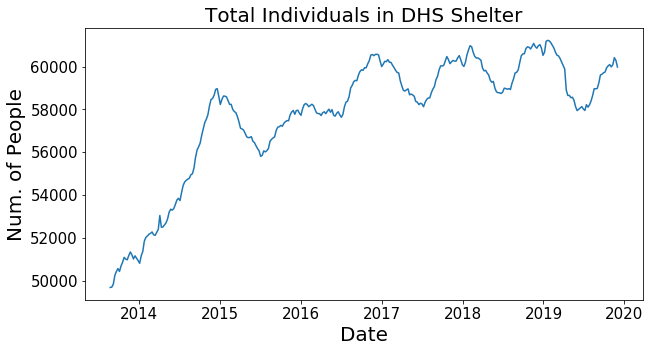

In [8]:
plt.figure(figsize = (10, 5))
plt.plot(weekly_df['total_individuals_in_shelter']) 
plt.title('Total Individuals in DHS Shelter', fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Num. of People', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

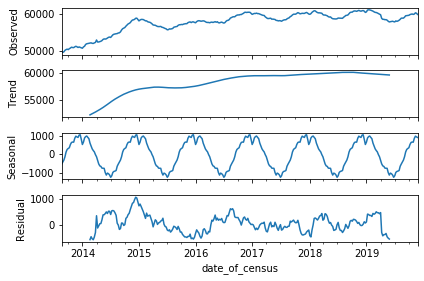

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].resample('W').mean())
decomp.plot();

** Observations **
- The total individuals in DHS Shelter increased rapidly from 2014 to 2015 and showed gradual increase until 2017. From 2017 until now, the upward trend has been stagnant.

- There is a sign of seasonality. Towards the end of the year through the beggining of the next year, the population in the shelter increases. This seasonality was not prominent from 2013 to 2014 and 2015 to 2016.

### Autocorrelation and  Partial Autocorrelation ( ` diff = 0` )

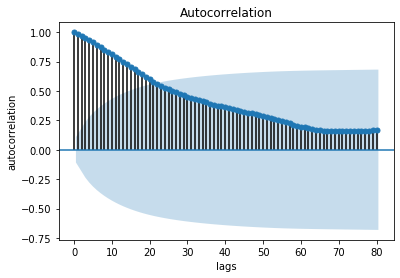

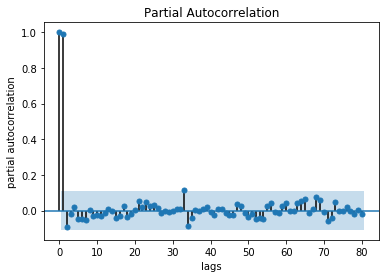

In [10]:
fc.acf_pacf(weekly_df['total_individuals_in_shelter'], 80)

**Observations**
- Autocorrelation Function (ACF) plot
    - The small lags values have large and positive correlations. This is a evidence of a trend.
    - In ACF plot above, no sharp cut-off was observed, which indicates that there is no sudden fluctuation in the data for the model to learn. Therefore, the moving average term, `q` can be selected to be 0.

- Partial Autocorrelation Function (PACF) plot
    - The evidence of seasonality observed in seasonal_decompose plot is not very evident in PACF plot.
    - In the PACF plot above, a sharp cut-off is identifed in lag 3. Lag 1 value is positive and, in such pattern, the autoregression term, `p` is the lag right before the sharpt cut-off. Therefore, `p` can be selected to be 1.

# ARIMA Model

--- 

### Part 1. Select `order = (p, d, q)` for the model

`p` (AR: AutoRegression)
- In the PACF plot, there is a sharp cut-off in lag 3.
- lag 1 value is positive.                  
- p-value is the lag right before the cut-off. 
Therefore, **p is 1**

In [11]:
fc.adf(weekly_df['total_individuals_in_shelter'].dropna())

Test Statistic   -2.475802
p-value           0.121473
dtype: float64

In [12]:
fc.adf(weekly_df['total_individuals_in_shelter'].diff(1).dropna())

Test Statistic   -4.664938
p-value           0.000098
dtype: float64

`d` (I: Integration)
- With the data that was differenced once, p-value from the ADF test was below 0.05
- This indicates that the data is stationary when d = 1. Therefore, **d is 1**

`q` (MA: Moving Average)
- In ACF plot, no sharp cut-off was observed. Therefore, **q is 0**

> **Result**:
`order = (1,1,0)` was selected.

---

### Part 2. Fit the model with the selected order terms

In [13]:
# Train / Test dataset split. Test size is 0.25.

train_test_cut = round(weekly_df.shape[0] * 0.75)

train = weekly_df['total_individuals_in_shelter'].iloc[:train_test_cut]
test = weekly_df['total_individuals_in_shelter'].iloc[train_test_cut:]

In [14]:
# Instantiate ARIMA model
model = ARIMA(endog = train.dropna(), # endog = Y variable
              order = (1, 1, 0), # (p, d, q) 
              freq = "W-SUN") 

# Fit model
arima_1_1_0 = model.fit()

In [15]:
# Generate prediction
preds_test = model.predict(params=arima_1_1_0.params,
                           start=test.index[0],
                           end=test.index[-1])

preds_train = model.predict(params=arima_1_1_0.params,
                            start=train.index[1], # Start at 1, instead of 0 becuase diff = 1
                            end=train.index[-1])

### Part 2. Analysis of ARIMA model

Becuase the model uses integration term of 1, the prediction from the ARIMA model is in the unit of 'the difference in the weekly population between two consecutive weeks', instead of 'the weekly population'. In order to examine the performance of the ARIMA model, I first looked at both `1) Predicted weekly difference` and `2) Predicted total individuals in shelter`.

**1. Predicted Weekly Difference**

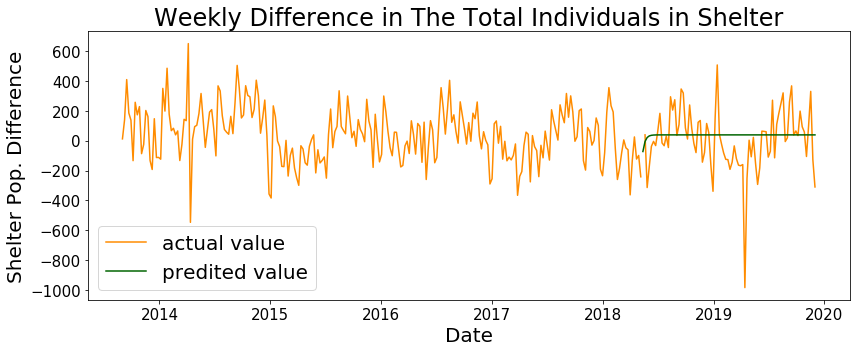

In [16]:
plt.figure(figsize=(12,5))
plt.plot(train.index[1:], train.diff(1).dropna().values, color = 'darkorange')
plt.plot(test.index[1:], test.diff(1).dropna().values, color = 'darkorange', label = 'actual value')
plt.plot(test.index, preds_test, color = 'darkgreen', label = 'predited value')
plt.title(label = 'Weekly Difference in The Total Individuals in Shelter', fontsize=24)
plt.legend(fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Shelter Pop. Difference', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**Observations (ARIMA Model)**
- The model does not seem to make meaningful predictions. The prediction converges quickly and draw a straight line.

In [17]:
# Calculate Residual
resids_test = list(test.diff(1).dropna() - preds_test[1:])
resids_train = list(train.diff(1).dropna() - preds_train)

{'root mean square error': 206.4289700638396}

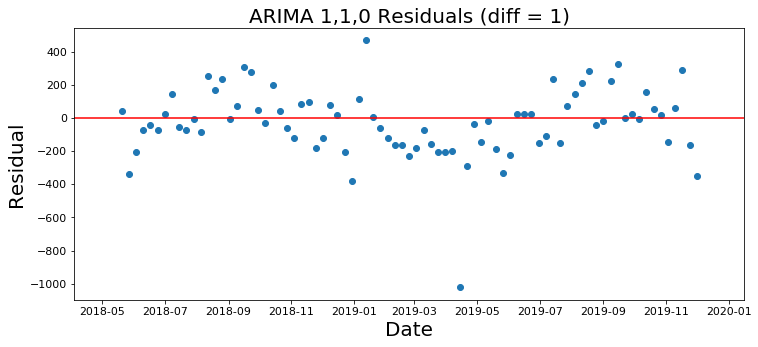

In [18]:
fc.evaluate(test[1:], resids_test, 'ARIMA 1,1,0 Residuals (diff = 1)')

**Observations (ARIMA Model)**
- The prediction converged quickly and drew a straight line without making meaningful predictions. Therefore, residuals followed the pattern of the differenced data.

** 2. Predicted Total Individuals in Shelter **

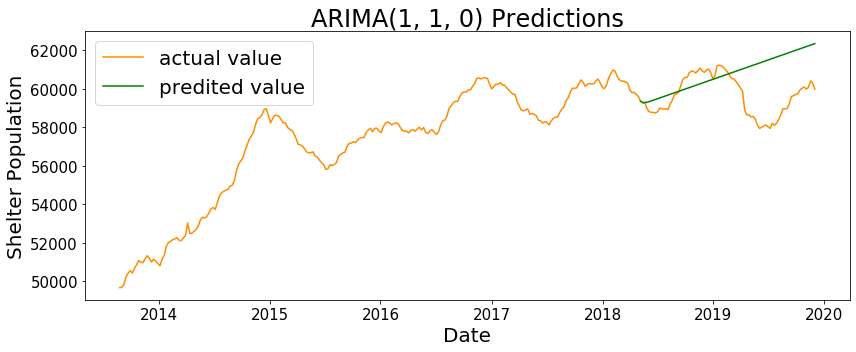

In [19]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, color = 'darkorange')
plt.plot(test.index, test.values, color = 'darkorange', label = 'actual value')
plt.plot(weekly_df.index[len(train.index)-1:], np.cumsum([train[-1]] + list(preds_test)), color = 'green', label = 'predited value')
plt.title(label = 'ARIMA(1, 1, 0) Predictions', fontsize=24)
plt.legend(fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Shelter Population', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**Observations (ARIMA Model)**
- The model does not seem to make meaningful predictions. The prediction converaged as a linear line upward.

In [20]:
# Append one datetime index prior to the test set's first index
# This compliments one missing date from differencing the data once
preds_test_original_index = [train.index[-1]] + list(test.index)

# Calculate `predicted total individuals in shelter` from `predicted weekly difference`
preds_test_original = np.cumsum([train[-1]] + list(preds_test))

# Calculate the residuals in the unit of `predicted total individuals in shelter`
resids_test_original = list([train[-1]] + list(test) - preds_test_original)

{'root mean square error': 1834.011135024872}

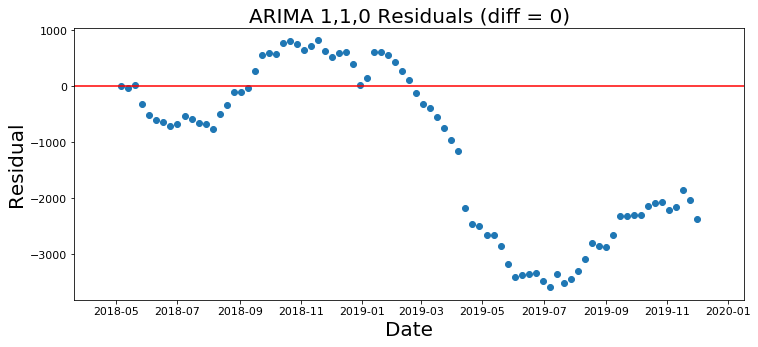

In [21]:
fc.evaluate(weekly_df.iloc[len(train.index)-1:,:], resids_test_original, 'ARIMA 1,1,0 Residuals (diff = 0)')

**Observations (ARIMA Model)**
- As the model did not make meaningful predictions and the prediction converaged as a linear line upward, the residual plot follows the pattern or the original data.
- Root Mean Square Error(RMSE): 1834

# SARIMA Model

---

### Manual Grid Search
- Use grid search to determine the best `seaonal_order` terms.

In [28]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in [3, 4, 51, 52]: 
                # testing monthly seasonality with 3,4
                # testing yearly seaonailty with 51, 52
                try:
                    print(f'Attempting to fit SARIMAX(1,1,0)x({P},{D},{Q},{S})')
                    # Fit SARIMAX model
                    model = SARIMAX(endog = train,
                                    order = (1, 1, 0),              # (p, d, q)
                                    seasonal_order = (P, D, Q, S),
                                    freq = "W-SUN").fit()  # (P, D, Q, S) 
                    

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (1, 1, 0)x({P},{D},{Q},{S}) is: {np.sqrt(mean_squared_error(test, preds))}')

                    # Save for final report.
                    if best_mse > np.sqrt(mean_squared_error(test, preds)):
                        best_mse = np.sqrt(mean_squared_error(test, preds))
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(1, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(1,1,0)x(0,0,0,3)
The MSE for (1, 1, 0)x(0,0,0,3) is: 1090.4740487209133
Attempting to fit SARIMAX(1,1,0)x(0,0,0,4)
The MSE for (1, 1, 0)x(0,0,0,4) is: 1090.4740487209133
Attempting to fit SARIMAX(1,1,0)x(0,0,0,51)
The MSE for (1, 1, 0)x(0,0,0,51) is: 1090.4740487209133
Attempting to fit SARIMAX(1,1,0)x(0,0,0,52)
The MSE for (1, 1, 0)x(0,0,0,52) is: 1090.4740487209133
Attempting to fit SARIMAX(1,1,0)x(0,1,0,3)
The MSE for (1, 1, 0)x(0,1,0,3) is: 8123.855779782445
Attempting to fit SARIMAX(1,1,0)x(0,1,0,4)
The MSE for (1, 1, 0)x(0,1,0,4) is: 5706.956560560639
Attempting to fit SARIMAX(1,1,0)x(0,1,0,51)
The MSE for (1, 1, 0)x(0,1,0,51) is: 1002.7387790474762
Attempting to fit SARIMAX(1,1,0)x(0,1,0,52)
The MSE for (1, 1, 0)x(0,1,0,52) is: 1070.7392317608778
Attempting to fit SARIMAX(1,1,0)x(0,2,0,3)
The MSE for (1, 1, 0)x(0,2,0,3) is: 11537.851027807652
Attempting to fit SARIMAX(1,1,0)x(0,2,0,4)
The MSE for (1, 1, 0)x(0,2,0,4) is: 12768.974512673632
Attempting to 

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(0,1,1,51) is: 1322.5700205089347
Attempting to fit SARIMAX(1,1,0)x(0,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(0,1,1,52) is: 1279.059620054947
Attempting to fit SARIMAX(1,1,0)x(0,2,1,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(0,2,1,3) is: 15370.806005145932
Attempting to fit SARIMAX(1,1,0)x(0,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(0,2,1,4) is: 10669.251899649706
Attempting to fit SARIMAX(1,1,0)x(0,2,1,51)
Attempting to fit SARIMAX(1,1,0)x(0,2,1,52)
Attempting to fit SARIMAX(1,1,0)x(0,0,2,3)
The MSE for (1, 1, 0)x(0,0,2,3) is: 1101.1136254303183
Attempting to fit SARIMAX(1,1,0)x(0,0,2,4)
The MSE for (1, 1, 0)x(0,0,2,4) is: 1144.7604484357985
Attempting to fit SARIMAX(1,1,0)x(0,0,2,51)
Attempting to fit SARIMAX(1,1,0)x(0,0,2,52)
Attempting to fit SARIMAX(1,1,0)x(0,1,2,3)
The MSE for (1, 1, 0)x(0,1,2,3) is: 1316.8806364575719
Attempting to fit SARIMAX(1,1,0)x(0,1,2,4)
The MSE for (1, 1, 0)x(0,1,2,4) is: 1317.2904123911326
Attempting to fit SARIMAX(1,1,0)x(0,1,2,51)
Attempting to fit SARIMAX(1,1,0)x(0,1,2,52)
Attempting to fit SARIMAX(1,1,0)x(0,2,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(0,2,2,3) is: 10422.840179655223
Attempting to fit SARIMAX(1,1,0)x(0,2,2,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(0,2,2,4) is: 9677.213815863839
Attempting to fit SARIMAX(1,1,0)x(0,2,2,51)
Attempting to fit SARIMAX(1,1,0)x(0,2,2,52)
Attempting to fit SARIMAX(1,1,0)x(1,0,0,3)
The MSE for (1, 1, 0)x(1,0,0,3) is: 1104.622114603019
Attempting to fit SARIMAX(1,1,0)x(1,0,0,4)
The MSE for (1, 1, 0)x(1,0,0,4) is: 1140.267462600502
Attempting to fit SARIMAX(1,1,0)x(1,0,0,51)
The MSE for (1, 1, 0)x(1,0,0,51) is: 1011.4789300805788
Attempting to fit SARIMAX(1,1,0)x(1,0,0,52)
The MSE for (1, 1, 0)x(1,0,0,52) is: 846.1620816678513
Attempting to fit SARIMAX(1,1,0)x(1,1,0,3)
The MSE for (1, 1, 0)x(1,1,0,3) is: 8106.975894604463
Attempting to fit SARIMAX(1,1,0)x(1,1,0,4)
The MSE for (1, 1, 0)x(1,1,0,4) is: 6239.3007076505755
Attempting to fit SARIMAX(1,1,0)x(1,1,0,51)
The MSE for (1, 1, 0)x(1,1,0,51) is: 1109.9475570860448
Attempting to fit SARIMAX(1,1,0)x(1,1,0,52)
The MSE for (1, 1, 0)x(1,1,0,52) is: 1097.036333473482
Attempting to fit SARIMAX(1,1,0)x(1,2,0,3)
The MSE for (1, 1, 0)x(1,2,0

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(1,1,1,51) is: 1627.8814753050951
Attempting to fit SARIMAX(1,1,0)x(1,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(1,1,1,52) is: 1213.175870147879
Attempting to fit SARIMAX(1,1,0)x(1,2,1,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(1,2,1,3) is: 13968.404126654928
Attempting to fit SARIMAX(1,1,0)x(1,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(1,2,1,4) is: 10235.69721800668
Attempting to fit SARIMAX(1,1,0)x(1,2,1,51)
Attempting to fit SARIMAX(1,1,0)x(1,2,1,52)
Attempting to fit SARIMAX(1,1,0)x(1,0,2,3)
The MSE for (1, 1, 0)x(1,0,2,3) is: 1306.6064963807426
Attempting to fit SARIMAX(1,1,0)x(1,0,2,4)
The MSE for (1, 1, 0)x(1,0,2,4) is: 1251.0015858331215
Attempting to fit SARIMAX(1,1,0)x(1,0,2,51)
Attempting to fit SARIMAX(1,1,0)x(1,0,2,52)
Attempting to fit SARIMAX(1,1,0)x(1,1,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(1,1,2,3) is: 5304.236279852406
Attempting to fit SARIMAX(1,1,0)x(1,1,2,4)
The MSE for (1, 1, 0)x(1,1,2,4) is: 1828.798141544021
Attempting to fit SARIMAX(1,1,0)x(1,1,2,51)
Attempting to fit SARIMAX(1,1,0)x(1,1,2,52)
Attempting to fit SARIMAX(1,1,0)x(1,2,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(1,2,2,3) is: 15406.338597210492
Attempting to fit SARIMAX(1,1,0)x(1,2,2,4)
The MSE for (1, 1, 0)x(1,2,2,4) is: 10675.02221089465
Attempting to fit SARIMAX(1,1,0)x(1,2,2,51)
Attempting to fit SARIMAX(1,1,0)x(1,2,2,52)
Attempting to fit SARIMAX(1,1,0)x(2,0,0,3)
The MSE for (1, 1, 0)x(2,0,0,3) is: 1117.7650544467858
Attempting to fit SARIMAX(1,1,0)x(2,0,0,4)
The MSE for (1, 1, 0)x(2,0,0,4) is: 1212.481684202448
Attempting to fit SARIMAX(1,1,0)x(2,0,0,51)
The MSE for (1, 1, 0)x(2,0,0,51) is: 1044.8092603131838
Attempting to fit SARIMAX(1,1,0)x(2,0,0,52)
The MSE for (1, 1, 0)x(2,0,0,52) is: 763.7543645368916
Attempting to fit SARIMAX(1,1,0)x(2,1,0,3)
The MSE for (1, 1, 0)x(2,1,0,3) is: 7050.117964045677
Attempting to fit SARIMAX(1,1,0)x(2,1,0,4)
The MSE for (1, 1, 0)x(2,1,0,4) is: 6412.238520251785
Attempting to fit SARIMAX(1,1,0)x(2,1,0,51)
The MSE for (1, 1, 0)x(2,1,0,51) is: 1190.4121595206398
Attempting to fit SARIMAX(1,1,0)x(2,1,0,52)
The MSE for (1, 1, 0)x(2,1,0

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(2,1,1,51) is: 1963.7779825629502
Attempting to fit SARIMAX(1,1,0)x(2,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 1, 0)x(2,1,1,52) is: 1545.8172873208503
Attempting to fit SARIMAX(1,1,0)x(2,2,1,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(2,2,1,3) is: 11319.708401290454
Attempting to fit SARIMAX(1,1,0)x(2,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(2,2,1,4) is: 10016.260243158013
Attempting to fit SARIMAX(1,1,0)x(2,2,1,51)
Attempting to fit SARIMAX(1,1,0)x(2,2,1,52)
Attempting to fit SARIMAX(1,1,0)x(2,0,2,3)
The MSE for (1, 1, 0)x(2,0,2,3) is: 657.8892833807305
Attempting to fit SARIMAX(1,1,0)x(2,0,2,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(2,0,2,4) is: 587.9447023504697
Attempting to fit SARIMAX(1,1,0)x(2,0,2,51)
Attempting to fit SARIMAX(1,1,0)x(2,0,2,52)
Attempting to fit SARIMAX(1,1,0)x(2,1,2,3)
The MSE for (1, 1, 0)x(2,1,2,3) is: 7145.539438088611
Attempting to fit SARIMAX(1,1,0)x(2,1,2,4)
The MSE for (1, 1, 0)x(2,1,2,4) is: 2341.242146948253
Attempting to fit SARIMAX(1,1,0)x(2,1,2,51)
Attempting to fit SARIMAX(1,1,0)x(2,1,2,52)
Attempting to fit SARIMAX(1,1,0)x(2,2,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (1, 1, 0)x(2,2,2,3) is: 12416.404445473418
Attempting to fit SARIMAX(1,1,0)x(2,2,2,4)
The MSE for (1, 1, 0)x(2,2,2,4) is: 4460.423285678584
Attempting to fit SARIMAX(1,1,0)x(2,2,2,51)
Attempting to fit SARIMAX(1,1,0)x(2,2,2,52)
Our model that minimizes MSE on the testing data is the SARIMAX(1, 1, 0)x(2,2,0,51).
This model has an MSE of 546.140164822024.


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Gridsearch indicates that **SARIMAX(0, 1, 0)x(2,2,0,51)** minimizes MSE.

In [32]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 51) model.
model = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (2, 2, 0, 51), # (P, D, Q, S)
                 freq = 'W-SUN').fit() 

In [33]:
# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])

In [37]:
resids = list(test - preds)

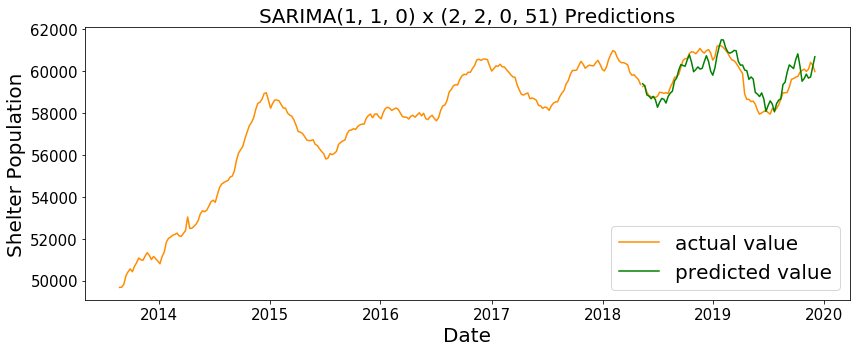

In [42]:
# Plot data.
plt.figure(figsize=(12,5))
plt.plot(train, color = 'darkorange')
plt.plot(test, color = 'darkorange', label = 'actual value')
plt.plot(preds, color = 'green', label = 'predicted value')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 51) Predictions', fontsize=20)
plt.legend(fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Shelter Population', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

{'root mean square error': 560.4296636303806}

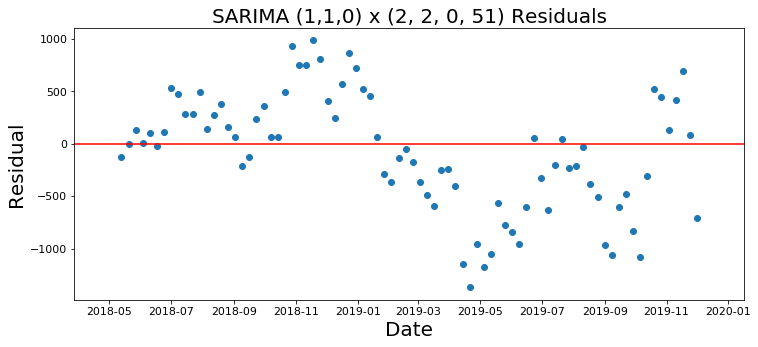

In [43]:
fc.evaluate(test, resids, 'SARIMA (1,1,0) x (2, 2, 0, 51) Residuals')

**Obserations**
- Using seasonal order terms significantly improved the performance of the model. Root mean square error for the SARIMA model is 560, which is a big improvement from the root mean square error of 1834 from the ARIMA model.